# Using reinforcement learning for combining search methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

# import loss function
from black_it.loss_functions.msm import MethodOfMomentsLoss

# import search methods
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.xgboost import XGBoostSampler

# import RL classes
from black_it.schedulers.rl.rl_scheduler import RLScheduler
from black_it.schedulers.rl.agents.epsilon_greedy import MABEpsilonGreedy
from black_it.schedulers.rl.envs.mab import MABCalibrationEnv

# import Calibrator class
from black_it.calibrator import Calibrator

In [2]:
# define a simple BH4 model as in Dyer et al. (2022)
def BH4(theta, N, seed):
    """
    Model from Brock and Hommes 1998.

    Eqs. (36-40) of Dyer et al., Black-box Bayesian inference for economic agent-based models (2022)

    Args:
        theta: parameters
        N: length of simulation
        seed: random seed

    Returns:
        simulated series
    """
    np.random.seed(seed=seed)

    R = 1.0
    sigma = 0.04

    beta = 120  # suggested values: 10, 120
    g1, b1, b4 = 0.0, 0.0, 0.0
    g4 = 1.01

    g2, b2, g3, b3 = theta[0], theta[1], theta[2], theta[3]
    # parameter set1: (g2, b2, g3, b3) = (0.9, 0.2, 0.9, −0.2)
    x_lag3 = 0.10
    x_lag2 = 0.10
    x_lag1 = 0.10

    x = np.zeros(N + 2)
    n = np.full(2, 0.50)

    x[0], x[1], x[2] = x_lag1, x_lag2, x_lag3

    g = np.array([g1, g2, g3, g4])
    b = np.array([b1, b2, b3, b4])

    for t in range(3, N + 1):
        den = np.sum(np.exp(beta * (x[t] - R * x[t - 1]) * (g * x[t - 2] + b - R * x[t - 1])))

        f = sum(np.exp(beta * (x[t] - R * x[t - 1]) * (g * x[t - 2] + b - R * x[t - 1])) * (g * x[t] + b) / den) / R

        x[t + 1] = np.random.normal(f, sigma / R)

    return np.atleast_2d(x[2:]).T

Text(0, 0.5, 'y(t)')

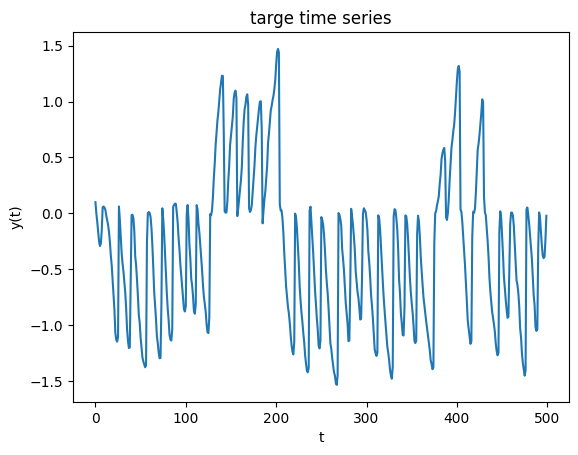

In [3]:
# generate synthetic target series (parameter set 1 of [Dyer et al. (2022)])
target_params = [0.9, 0.2, 0.9, -0.2]
target_series = BH4(theta=target_params, N=500, seed=0)
plt.plot(target_series)
plt.title("targe time series")
plt.xlabel("t")
plt.ylabel("y(t)")

In [4]:
# define a method-of-moments loss function
loss = MethodOfMomentsLoss()

# define some bounds and precisions on the parameters
bounds = [[0.0, 0.0, 0.0, -1.0], [1.0, 1.0, 1.0, 0.0]]
precisions = [0.01, 0.01, 0.01, 0.01]

In [5]:
# define a MAB learning agent and a MAB environment
alpha, eps = 0.1, 0.1
agent = MABEpsilonGreedy(alpha=alpha, eps=eps, initial_values=0.05, n_actions=3)
env = MABCalibrationEnv(nb_samplers=3)

In [6]:
# define a set of samplers, and pass them to a reinforcement learning scheduler
best_batch = BestBatchSampler(1)
random_forest = RandomForestSampler(1)
xg_boost = XGBoostSampler(1)

rl_scheduler = RLScheduler(agent=agent, env=env, samplers=[random_forest, xg_boost, best_batch])

In [7]:
# initialise a calibrator object
cal = Calibrator(
    scheduler=rl_scheduler,
    loss_function=loss,
    model=BH4,
    parameters_bounds=bounds,
    sim_length=500,  # simulation length for each parameter combination
    ensemble_size=1,  # number of repetitions for each parameter combination
    parameters_precision=precisions,
    real_data=target_series,
    random_state=0,
    n_jobs=1,
)


***
Number of free params:       4.
Explorable param space size: 104060401.
***

Selecting 1 processes for the parallel evaluation of the model


In [8]:
# calibrate for a number of epochs
params, losses = cal.calibrate(150)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 169569.13
---->   avg loss new params: 169569.13
----> avg loss exist params: 169569.13
---->         curr min loss: 169569.1271084015
====>    total elapsed time: 0.0s

BATCH NUMBER:   2
PARAMS SAMPLED: 1

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 5.51
---->   avg loss new params: 5.51
----> avg loss exist params: 84787.32
---->         curr min loss: 5.511641321161405
====>    total elapsed time: 0.3s

BATCH NUMBER:   3
PARAMS SAMPLED: 2

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.63
---->   avg loss new params: 4.63
----> avg loss exist params: 56526.42
---->         curr min loss: 4.628565393502145
====>    total elapsed time: 0.3s

BATCH NUMBER:   4
PARAMS SAMPLED: 3

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 9.2
-

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 28266.95
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 0.3s

BATCH NUMBER:   7
PARAMS SAMPLED: 6

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 14.72
---->   avg loss new params: 14.72
----> avg loss exist params: 24230.92
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 0.3s

BATCH NUMBER:   8
PARAMS SAMPLED: 7

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 21203.34
---->         curr min loss: 3.00799724395391
====>    total elapsed time: 0.3s

BATCH NUMBER:   9
PARAMS SAMPLED: 8

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.47
---->   avg loss new params: 0.47
----> avg loss exist params: 18847.46
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.4s

BATCH NUMBER:   10
PARAMS SAMPLED: 9

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.74
---->   avg loss new params: 0.74
----> avg loss exist params: 16962.79
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   11
PARAMS SAMPLED: 10

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.2
---->   avg loss new params: 4.2
----> avg loss exist params: 15

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 14136.86
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   13
PARAMS SAMPLED: 12

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 13050.2
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   14
PARAMS SAMPLED: 13

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.31
---->   avg loss new params: 1.31
----> avg loss exist params: 12118.13
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   15
PARAMS SAMPLED: 14

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 5.16
---->   avg loss new params: 5.16
----> avg loss exist params: 11310.6
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   16
PARAMS SAMPLED: 15

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 10604.33
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   17
PARAMS SAMPLED: 16

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 9981.15
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   18
PARAMS SAMPLED: 17

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 9427.21
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   19
PARAMS SAMPLED: 18

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 8931.58
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   20
PARAMS SAMPLED: 19

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 3.9
---->   avg loss new params: 3.9
----> avg loss exist params: 8485.2
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   21
PARAMS SAMPLED: 20

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 8081.63
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   22
PARAMS SAMPLED: 21

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 12.25
---->   avg loss new params: 12.25
----> avg loss exist params: 7714.84
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.3s

BATCH NUMBER:   23
PARAMS SAMPLED: 22

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.61
---->   avg loss new params: 2.61
----> avg loss exist params: 7379.52
---->         curr min loss: 0.46756743946222523
====>    total elapsed time: 0.0s

BATCH NUMBER:   24
PARAMS SAMPLED: 23

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.5
---->   avg loss new params: 0.5
----> avg loss exist params: 7072.

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 4467.93
---->         curr min loss: 0.4434231579477172
====>    total elapsed time: 0.3s

BATCH NUMBER:   39
PARAMS SAMPLED: 38

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 3.98
---->   avg loss new params: 3.98
----> avg loss exist params: 4353.47
---->         curr min loss: 0.4434231579477172
====>    total elapsed time: 0.3s

BATCH NUMBER:   40
PARAMS SAMPLED: 39

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.38
---->   avg loss new params: 4.38
----> avg loss exist params: 4244.74
---->         curr min loss: 0.4434231579477172
====>    total elapsed time: 0.0s

BATCH NUMBER:   41
PARAMS SAMPLED: 40

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.66
---->   avg loss new params: 0.66
----> avg loss exist params: 4141.23


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 7.13
---->   avg loss new params: 7.13
----> avg loss exist params: 2878.58
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.3s

BATCH NUMBER:   60
PARAMS SAMPLED: 59

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.39
---->   avg loss new params: 1.39
----> avg loss exist params: 2830.62
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.0s

BATCH NUMBER:   61
PARAMS SAMPLED: 60

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.43
---->   avg loss new params: 1.43
----> avg loss exist params: 2784.24
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.3s

BATCH NUMBER:   62
PARAMS SAMPLED: 61

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.48
---->   avg loss new params: 0.48
----> avg loss exist params: 2739.

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2461.89
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.3s

BATCH NUMBER:   70
PARAMS SAMPLED: 69

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2426.86
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.0s

BATCH NUMBER:   71
PARAMS SAMPLED: 70

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.21
---->   avg loss new params: 2.21
----> avg loss exist params: 2392.71
---->         curr min loss: 0.38850175528963965
====>    total elapsed time: 0.0s

BATCH NUMBER:   72
PARAMS SAMPLED: 71

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.39
---->   avg loss new params: 1.39
----> avg loss exist params: 235

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.37
---->   avg loss new params: 0.37
----> avg loss exist params: 2940.3
---->         curr min loss: 0.35590648834873373
====>    total elapsed time: 0.3s

BATCH NUMBER:   98
PARAMS SAMPLED: 97

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.89
---->   avg loss new params: 1.89
----> avg loss exist params: 2910.31
---->         curr min loss: 0.35590648834873373
====>    total elapsed time: 0.0s

BATCH NUMBER:   99
PARAMS SAMPLED: 98

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.32
---->   avg loss new params: 0.32
----> avg loss exist params: 2880.92
---->         curr min loss: 0.3239611897146627
====>    total elapsed time: 0.0s

BATCH NUMBER:   100
PARAMS SAMPLED: 99

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.02
---->   avg loss new params: 2.02
----> avg loss exist params: 2852.13
---

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.ex

----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 3332.42
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   124
PARAMS SAMPLED: 123

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 1.27
---->   avg loss new params: 1.27
----> avg loss exist params: 3305.55
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   125
PARAMS SAMPLED: 124

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.44
---->   avg loss new params: 2.44
----> avg loss exist params: 3279.13
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   126
PARAMS SAMPLED: 125

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 6.27
---->   avg loss new params: 6.27
----> avg loss exist params:

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 3.2
---->   avg loss new params: 3.2
----> avg loss exist params: 3129.12
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   132
PARAMS SAMPLED: 131

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 8.24
---->   avg loss new params: 8.24
----> avg loss exist params: 3105.47
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   133
PARAMS SAMPLED: 132

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.05
---->   avg loss new params: 2.05
----> avg loss exist params: 3082.14
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   134
PARAMS SAMPLED: 133

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 4.98
---->   avg loss new params: 4.98
----> avg loss exist params: 305

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.76
---->   avg loss new params: 2.76
----> avg loss exist params: 2992.29
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   138
PARAMS SAMPLED: 137

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2970.68
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   139
PARAMS SAMPLED: 138

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.32
---->   avg loss new params: 0.32
----> avg loss exist params: 2949.31
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   140
PARAMS SAMPLED: 139

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.27
---->   avg loss new params: 0.27
----> avg loss exist params: 2928.24
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   141
PARAMS SAMPLED: 140

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 3.61
---->   avg loss new params: 3.61
----> avg loss exist params: 2907.5
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   142
PARAMS SAMPLED: 141

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.28
---->   avg loss new params: 0.28
----> avg loss exist params: 2887.03
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   143
PARAMS SAMPLED: 142

METHOD: RandomForestSampler


/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in divide
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 10.24
---->   avg loss new params: 10.24
----> avg loss exist params: 2866.91
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   144
PARAMS SAMPLED: 143

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.26
---->   avg loss new params: 2.26
----> avg loss exist params: 2847.02
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   145
PARAMS SAMPLED: 144

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 0.32
---->   avg loss new params: 0.32
----> avg loss exist params: 2827.38
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s

BATCH NUMBER:   146
PARAMS SAMPLED: 145

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.07
---->   avg loss new params: 2.07
----> avg loss exist params:

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:40: RuntimeWarning: overflow encountered in exp
  den = np.sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])))
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: overflow encountered in exp
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_30416/1649505445.py:42: RuntimeWarning: invalid value encountered in multiply
  f = sum(np.exp(beta*(x[t] - R*x[t-1]) * (g*x[t-2] + b - R*x[t-1])) * (g*x[t] + b) / den) / R


----> sim exec elapsed time: 0.0s
---->   min loss new params: 2.34
---->   avg loss new params: 2.34
----> avg loss exist params: 2751.59
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.4s

BATCH NUMBER:   150
PARAMS SAMPLED: 149

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 5.67
---->   avg loss new params: 5.67
----> avg loss exist params: 2733.28
---->         curr min loss: 0.26493923967477573
====>    total elapsed time: 0.0s


In [9]:
# confront target patrameters with obtained parameters
print(target_params)
print(params[0])

[0.9, 0.2, 0.9, -0.2]
[ 0.63  0.41  0.8  -0.4 ]


In [10]:
# integers for each method used
cal.samplers_id_table

{'RandomForestSampler': 0,
 'XGBoostSampler': 1,
 'BestBatchSampler': 2,
 'HaltonSampler': 3}

In [11]:
# the action selected by the RL scheduler
cal.method_samp

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 2,
       0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1])

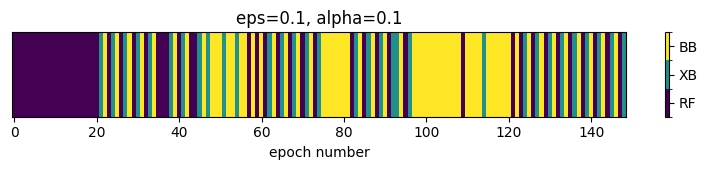

In [14]:
actions = cal.method_samp
actions = np.array(np.tile(actions[1:], (20, 1)))
cmap2 = matplotlib.cm.viridis
cmap2_r = ListedColormap(cmap2.colors[::-1])
bounds = [0, 1, 2, 3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

plt.figure(figsize=(8, 1.8))
plt.imshow(actions, aspect="auto", cmap=cmap2)

plt.xlabel("epoch number")

plt.yticks([])
plt.title(f"eps={eps}, alpha={alpha}")

cbar = plt.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap2), orientation="vertical", ticks=[0.5, 1.5, 2.5], ax=plt.gca()
)

cbar.ax.set_yticklabels(["RF", "XB", "BB"])

plt.tight_layout()

(0.0, 1.0)

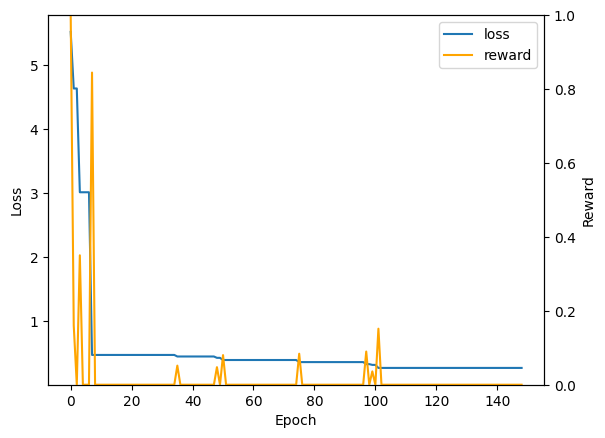

In [15]:
# the convergence of the loss and the reward signals

cum_min = np.minimum.accumulate(cal.losses_samp)
rewards = -((np.roll(cum_min, -1) - cum_min) / cum_min)[:-1]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
lns1 = ax1.plot(cum_min[1:], color="tab:blue", label="loss")
lns2 = ax2.plot(rewards, color="orange", label="reward")

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Reward")

ax2.set_ylim(0.0, 1.0)